# Two-Venue Latency Arbitrage Stress Study

This notebook simulates a simple cross-venue arbitrage workflow between Venue A and Venue B with:
- signal latency (decision to execution delay)
- transfer delay/cooldown constraints
- transaction costs
- sensitivity analysis by latency and transfer delay

In [1]:
from __future__ import annotations

import json
import random
from pathlib import Path

import matplotlib.pyplot as plt

result_path = Path('../outputs/baseline_mm_result.json')
if not result_path.exists():
    raise FileNotFoundError('Missing outputs/baseline_mm_result.json. Run `make report` first.')

with result_path.open('r', encoding='utf-8') as f:
    payload = json.load(f)

base_mid = payload['series']['mid']
n = len(base_mid)
n

2500

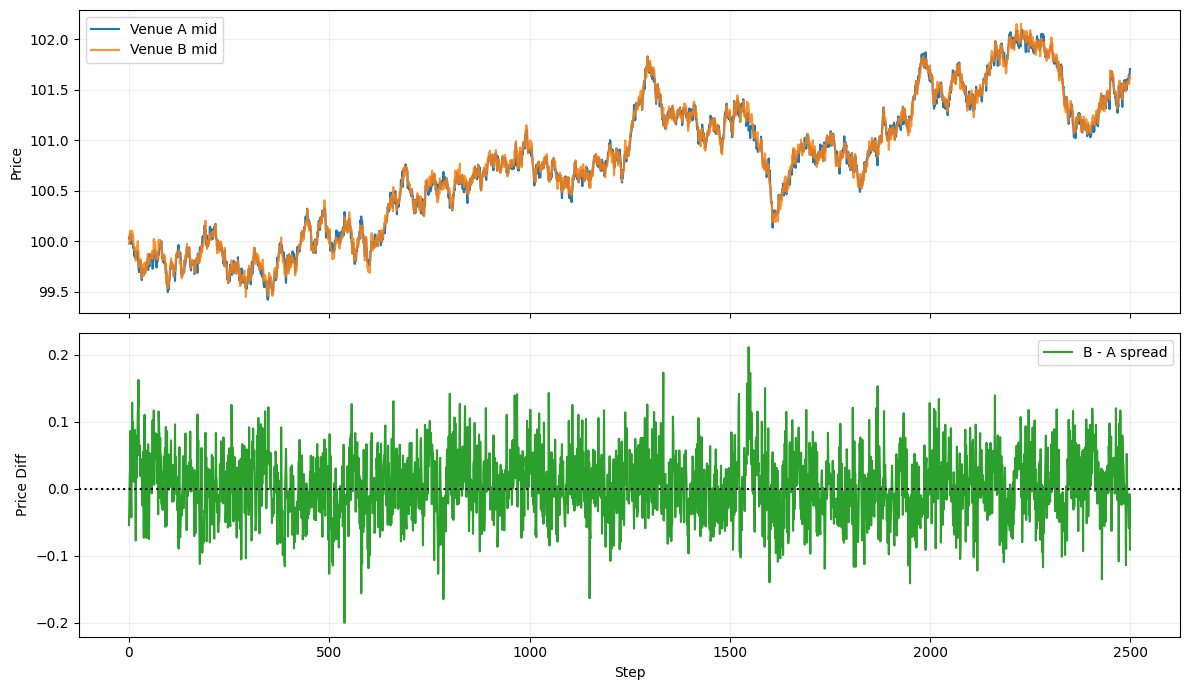

In [2]:
# Build two synthetic venues around the baseline path.
rng = random.Random(21)
venue_a = []
venue_b = []
spread_a = []
spread_b = []

basis = 0.0
for m in base_mid:
    basis += -0.08 * basis + rng.gauss(0.0, 0.01)
    pa = m + rng.gauss(0.0, 0.03)
    pb = m + basis + rng.gauss(0.0, 0.03)
    venue_a.append(pa)
    venue_b.append(pb)
    spread_a.append(0.04 + abs(rng.gauss(0.0, 0.01)))
    spread_b.append(0.05 + abs(rng.gauss(0.0, 0.01)))

fig, ax = plt.subplots(2, 1, figsize=(12, 7), sharex=True)
ax[0].plot(venue_a, label='Venue A mid', color='tab:blue')
ax[0].plot(venue_b, label='Venue B mid', color='tab:orange', alpha=0.85)
ax[0].set_ylabel('Price')
ax[0].legend()
ax[0].grid(alpha=0.2)

diff = [b - a for a, b in zip(venue_a, venue_b)]
ax[1].plot(diff, color='tab:green', label='B - A spread')
ax[1].axhline(0.0, color='black', linestyle=':')
ax[1].set_ylabel('Price Diff')
ax[1].set_xlabel('Step')
ax[1].legend()
ax[1].grid(alpha=0.2)

plt.tight_layout()
plt.show()

In [3]:
def run_latency_arb(latency_steps: int, transfer_delay: int, threshold: float = 0.12):
    """
    Arbitrage rule:
    - If B-A > threshold, buy A and sell B (expect convergence)
    - If A-B > threshold, buy B and sell A
    Executions happen after latency_steps; new trades blocked until transfer_delay passes.
    """
    fee_bps = 2.0
    qty = 1.0

    pnl = 0.0
    pnl_path = []
    trades = 0
    wins = 0
    losses = 0
    cooldown_until = -1

    for t in range(n - latency_steps - 1):
        spread_now = venue_b[t] - venue_a[t]
        if t < cooldown_until:
            pnl_path.append(pnl)
            continue

        side = 0
        if spread_now > threshold:
            side = 1   # buy A, sell B
        elif -spread_now > threshold:
            side = -1  # buy B, sell A

        if side == 0:
            pnl_path.append(pnl)
            continue

        te = t + latency_steps
        tx = te + 1
        if tx >= n:
            pnl_path.append(pnl)
            continue

        a_in = venue_a[te]
        b_in = venue_b[te]
        a_out = venue_a[tx]
        b_out = venue_b[tx]

        # gross PnL on one-step convergence after delayed execution.
        if side == 1:
            gross = qty * ((a_out - a_in) - (b_out - b_in))
            notional = qty * (a_in + b_in)
        else:
            gross = qty * ((b_out - b_in) - (a_out - a_in))
            notional = qty * (a_in + b_in)

        fees = notional * (fee_bps / 10_000.0)
        trade_pnl = gross - fees
        pnl += trade_pnl
        trades += 1
        if trade_pnl >= 0:
            wins += 1
        else:
            losses += 1

        cooldown_until = t + transfer_delay
        pnl_path.append(pnl)

    while len(pnl_path) < n:
        pnl_path.append(pnl)

    win_rate = wins / trades if trades else 0.0
    return {
        'final_pnl': pnl,
        'trades': trades,
        'win_rate': win_rate,
        'losses': losses,
        'pnl_path': pnl_path,
    }

In [4]:
baseline = run_latency_arb(latency_steps=1, transfer_delay=5, threshold=0.12)
baseline['final_pnl'], baseline['trades'], baseline['win_rate']

(-0.8842077312755661, 36, 0.3333333333333333)

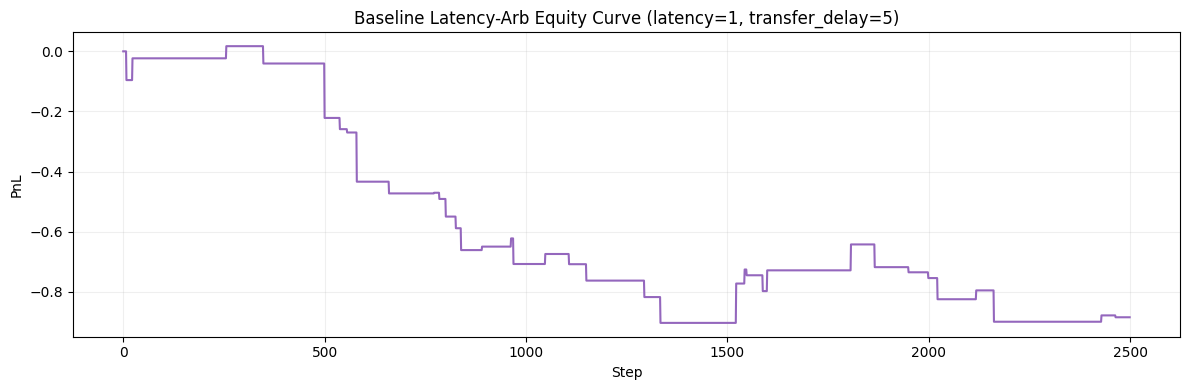

In [5]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(baseline['pnl_path'], color='tab:purple')
ax.set_title('Baseline Latency-Arb Equity Curve (latency=1, transfer_delay=5)')
ax.set_xlabel('Step')
ax.set_ylabel('PnL')
ax.grid(alpha=0.2)
plt.tight_layout()
plt.show()

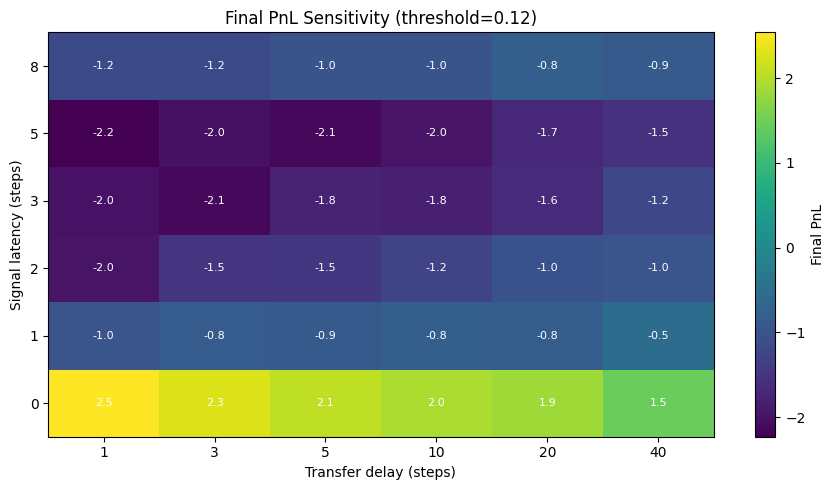

In [6]:
latencies = [0, 1, 2, 3, 5, 8]
delays = [1, 3, 5, 10, 20, 40]
threshold = 0.12

heat = []
for L in latencies:
    row = []
    for D in delays:
        out = run_latency_arb(latency_steps=L, transfer_delay=D, threshold=threshold)
        row.append(out['final_pnl'])
    heat.append(row)

fig, ax = plt.subplots(figsize=(9, 5))
im = ax.imshow(heat, aspect='auto', origin='lower')
ax.set_xticks(range(len(delays)))
ax.set_xticklabels(delays)
ax.set_yticks(range(len(latencies)))
ax.set_yticklabels(latencies)
ax.set_xlabel('Transfer delay (steps)')
ax.set_ylabel('Signal latency (steps)')
ax.set_title(f'Final PnL Sensitivity (threshold={threshold})')

for i in range(len(latencies)):
    for j in range(len(delays)):
        ax.text(j, i, f'{heat[i][j]:.1f}', ha='center', va='center', color='white', fontsize=8)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Final PnL')
plt.tight_layout()
plt.show()

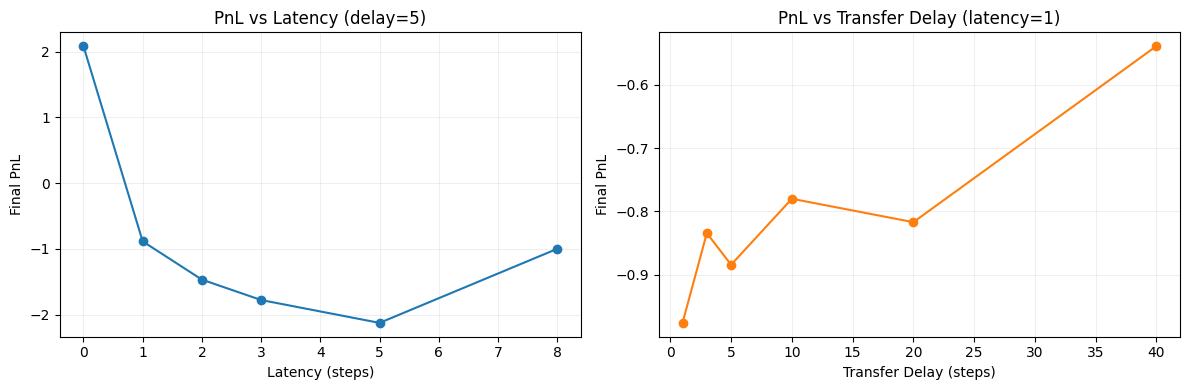

In [7]:
# One-dimensional slices for readability.
fixed_delay = 5
pnl_by_latency = []
for L in latencies:
    pnl_by_latency.append(run_latency_arb(latency_steps=L, transfer_delay=fixed_delay, threshold=threshold)['final_pnl'])

fixed_latency = 1
pnl_by_delay = []
for D in delays:
    pnl_by_delay.append(run_latency_arb(latency_steps=fixed_latency, transfer_delay=D, threshold=threshold)['final_pnl'])

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(latencies, pnl_by_latency, marker='o', color='tab:blue')
ax[0].set_title(f'PnL vs Latency (delay={fixed_delay})')
ax[0].set_xlabel('Latency (steps)')
ax[0].set_ylabel('Final PnL')
ax[0].grid(alpha=0.2)

ax[1].plot(delays, pnl_by_delay, marker='o', color='tab:orange')
ax[1].set_title(f'PnL vs Transfer Delay (latency={fixed_latency})')
ax[1].set_xlabel('Transfer Delay (steps)')
ax[1].set_ylabel('Final PnL')
ax[1].grid(alpha=0.2)

plt.tight_layout()
plt.show()

## Interpretation

Typical pattern: as latency increases, edge decay dominates and win-rate drops.
Transfer delay creates opportunity cost by blocking re-entry after a trade.

This should eventually be replaced by a true event-level two-venue simulator with queue and execution uncertainty.